<a href="https://colab.research.google.com/github/a-maksimov/data_analysis/blob/main/tweepy_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook downloads twitter timeline of a user (3200 tweets max), preprocess the tweets and trains a word2vec model.
TODO: clean emojis.

# Set up the environment

In [672]:
!pip --quiet install tweepy

In [673]:
!pip --quiet install python-dotenv

In [674]:
!pip --quiet install spacy

In [675]:
#@title Download spaCy language packs

!python -m spacy download ru_core_news_sm --quiet
!python -m spacy download en_core_web_sm --quiet

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-01 12:12:17.287259: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-01 12:12:17.287550: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-01 12:12:17.287593: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

In [676]:
#@title Imports
import tweepy
from dotenv import load_dotenv
import time
from datetime import datetime
import os
import json
import csv
import pandas as pd
import re
import string
import spacy
from collections import defaultdict
import multiprocessing
from gensim.models import Word2Vec
from random import randint

In [677]:
load_dotenv('/content/drive/MyDrive/Secrets/.env')

True

# Download tweets

In [678]:
consumer_key=os.getenv('consumer_key')
consumer_secret=os.getenv('consumer_secret')
access_token_key=os.getenv('access_token_key')
access_token_secret=os.getenv('access_token_secret')

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_token_secret)

api = tweepy.API(auth)

In [679]:
#@title Twitter username and number of their tweets to download
twitter_username = 'elonmusk' #@param {type:"string"}
tweets_count = 3200 #@param {type:"integer"}
user = api.get_user(twitter_username)

In [680]:
#@title Fetch the tweets from Twitter
data = []
step = 200
data.extend(tweepy.Cursor(api.user_timeline, tweet_mode='extended', screen_name=twitter_username).items(step))
print(f'..{len(data)} tweets downloaded')
oldest = data[-1].id - 1
time.sleep(1)
for i in range(0, tweets_count - step, step):  
  print(f'getting tweets before id: {oldest}')
  # all subsequent requests use the max_id param to prevent duplicates
  data.extend(tweepy.Cursor(api.user_timeline, tweet_mode='extended', screen_name=twitter_username, max_id=oldest).items(step))
  # update the id of the oldest like minus one
  oldest = data[-1].id - 1
  print(f'..{len(data)} tweets downloaded')
  time.sleep(1)

..200 tweets downloaded
getting tweets before id: 1628667176902352895
..400 tweets downloaded
getting tweets before id: 1626314402197815295
..600 tweets downloaded
getting tweets before id: 1623382375584632833
..800 tweets downloaded
getting tweets before id: 1620284790405738496
..1000 tweets downloaded
getting tweets before id: 1616855485294215167
..1200 tweets downloaded
getting tweets before id: 1614106520920412160
..1400 tweets downloaded
getting tweets before id: 1608965398166392831
..1600 tweets downloaded
getting tweets before id: 1606348600212000767
..1800 tweets downloaded
getting tweets before id: 1604257617047609346
..2000 tweets downloaded
getting tweets before id: 1602737253494693888
..2200 tweets downloaded
getting tweets before id: 1600752140711972864
..2400 tweets downloaded
getting tweets before id: 1597728650019098623
..2600 tweets downloaded
getting tweets before id: 1595534031545765889
..2800 tweets downloaded
getting tweets before id: 1593674664009555970
..3000 twe

In [681]:
#@title Save tweets to a csv file
dt_string = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
fieldnames = ['id', 'text']
filename = f'{twitter_username}_{tweets_count}_{dt_string}.csv'
filepath = os.path.join(os.getcwd(), 'tweets/')

if not os.path.exists(filepath):
  os.mkdir(filepath)
with open(filepath + filename, 'w', encoding='utf-8') as file:
  writer = csv.DictWriter(file, fieldnames=fieldnames, extrasaction='ignore')
  writer.writeheader()   
  for tweet in data:
    try: # get full text if tweet is a retweet
      tweet_dict = dict(zip(fieldnames, [tweet.id, tweet.retweeted_status.full_text]))
    except:
      tweet_dict = dict(zip(fieldnames, [tweet.id, tweet.full_text]))
    writer.writerow(tweet_dict)

# Cleaning



In [682]:
#@title import to Pandas
df = pd.read_csv('/content/tweets/' + filename)

In [683]:
#@title Remove meantions, urls, RTs, symbols
#TODO Remove emojis

def brief_clean(text):
  text = re.sub('@[^\s]*\s', '', text)  # remove mentions
  text = re.sub('http\S*', '', text)  # remove urls
  text = text.replace('\n', ' ')  # replace newlines with space
  text = text.replace(',', ' ')  # remove commas
  text = re.sub(' +', ' ', text)  # replace multiple spaces with one space
  text = text.replace('RT', '')  # remove RTs
  text = text.lower().strip()  # make all lowercase
  signs = '«»—"…“"'
  text = text.translate(str.maketrans('', '', string.punctuation + signs))  # remove string.punctuation from the string
  return text

In [684]:
df['text_cleaned'] = df['text'].map(brief_clean)
df['text_cleaned'][1]

'intense'

In [685]:
language = "en" #@param ["ru", "en"]
if language == 'ru':
  nlp = spacy.load('ru_core_news_sm', disable=['ner', 'parser'])  # disabling Named Entity Recognition for speed
else:
  nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])  # disabling Named Entity Recognition for speed

In [686]:
#@title Now we lemmatize with stop words or without
# Lemmatizes and removes stopwords
# doc needs to be a spacy Doc object
def lemmatize(doc):
    text = [token.lemma_ for token in doc]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(text) > 2:
        return ' '.join(text)

def lemmatize_without_stops(doc):
    text = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(text) > 2:
        return ' '.join(text)

Taking advantage of spaCy .pipe() method to speed-up the cleaning process:

In [687]:
docs = nlp.pipe(df['text_cleaned'].values, batch_size=5000, n_process=-1)  # returns a generator of spacy Docs

In [688]:
t = time.time()

df['text_lem'] = pd.Series([lemmatize_without_stops(doc) for doc in docs], dtype='string')

print(f'Time to lemmatize: {round((time.time() - t), 2)} secs')

df

Time to lemmatize: 12.79 secs


,id,text,text_cleaned,text_lem
0,1630829002112811009,@neontaster 🔥🔥,🔥🔥,<NA>
1,1630828537870524416,@Rainmaker1973 Intense,intense,<NA>
2,1630827383602450432,@EvaFoxU 🤣,🤣,<NA>
3,1630825219429396480,@SawyerMerritt 🤣,🤣,<NA>
4,1630816472984330241,What do you call an infinite gear ratio?\nAll ...,what do you call an infinite gear ratio all to...,infinite gear ratio torque action
...,...,...,...,...
3187,1589022495189127169,Search within Twitter reminds me of Infoseek i...,search within twitter reminds me of infoseek i...,search twitter remind infoseek ' 98 lot well p...
3188,1589021467005816833,@CorySteuben @Erdayastronaut @live_munro Inter...,interesting,<NA>
3189,1589020949822963715,"@gchahal @TwitterBlue 42 mins to start, then s...",42 mins to start then several hours in a month...,42 min start hour month
3190,1589020644007874560,@BillyM2k @nikitabier We definitely need to in...,we definitely need to incent people to do a lo...,definitely need incent people lot interaction ...


In [691]:
df_clean = df[['text_lem']].dropna().drop_duplicates().reset_index()
df_clean

,index,text_lem
0,4,infinite gear ratio torque action
1,5,photo filter mislead 🤣 🤣
2,8,periodic reminder try twitter list greatly imp...
3,11,tesla int8 inference way efficient fp16 take l...
4,12,wow 9 year ago amazingly dependent russian eng...
...,...,...
1708,3182,go forward twitter handle engage impersonation...
1709,3185,fix search high priority
1710,3187,search twitter remind infoseek ' 98 lot well p...
1711,3189,42 min start hour month


In [692]:
#@title Calculate word frequency
docs = nlp.pipe(df['text_cleaned'].values, batch_size=5000, n_process=-1)  # returns a generator of spacy Docs
lem_without_stops = pd.Series([lemmatize_without_stops(doc) for doc in docs], dtype='string').dropna().drop_duplicates()

words_freq = defaultdict(int)
for tweet in lem_without_stops:
  for word in tweet.split():
    words_freq[word] += 1

word_freq_df = pd.DataFrame.from_dict(words_freq, orient='index', columns=['word_count']).reset_index().rename(columns = {'index': 'word'})
word_freq_df.sort_values('word_count', ascending=False).head(10)

,word,word_count
12,twitter,314
56,amp,194
312,tweet,105
283,people,97
100,like,94
61,"""",93
17,tesla,77
369,account,76
8,🤣,74
46,work,66


## Bigrams

We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.

https://radimrehurek.com/gensim/models/phrases.html

In [693]:
from gensim.models.phrases import Phrases, Phraser

Phrases() takes a list of list of words as input:

In [694]:
sent = [row.split() for row in df_clean['text_lem']]

Creates the relevant phrases from the list of sentences:

In [695]:
phrase_model = Phrases(sent, min_count=15)

In [696]:
bigram = Phraser(phrase_model)

In [697]:
sentences = bigram[sent]

In [698]:
#@title Show bigrams
bigram_freq = defaultdict(int)
for sentence in sentences:
  for word in sentence:
     if '_' in word:
      bigram_freq[word] += 1

bigram_freq_df = pd.DataFrame.from_dict(bigram_freq, orient='index', columns=['bigram_count'])
bigram_freq_df.sort_values('bigram_count', ascending=False).head(20)

,bigram_count
🤣_🤣,28
falcon_9,19
free_speech,18
🔥_🔥,16


# Model training

In [699]:
cores = multiprocessing.cpu_count()

The parameters:
* min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
* window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
* size = int - Dimensionality of the feature vectors. - (50, 300)
* sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
* alpha = float - The initial learning rate - (0.01, 0.05)
* min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
* negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
* workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [700]:
w2v_model = Word2Vec(min_count=2,
                     window=5,
                     size=300,
                     sample=5e-3, 
                     alpha=0.03, 
                     min_alpha=0.0001, 
                     negative=20,
                     workers=cores-1)

In [701]:
t = time.time()

w2v_model.build_vocab(sentences)

print(f'Time to build vocab: {round((time.time() - t), 2)} secs')
print(f'Vocabulary size: {len(w2v_model.wv.vocab)}')

Time to build vocab: 0.49 secs
Vocabulary size: 1816


In [702]:
t = time.time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

print(f'Time to train the model: {round((time.time() - t), 2)} secs')

Time to train the model: 4.8 secs


In [703]:
w2v_model.init_sims(replace=True)

# Test

In [704]:
#@title Select the word for showing the similarities
word = "tes" #@param {type:"string"}
w2v_model.wv.most_similar(positive=[word])

[('team', 0.9477834701538086),
 ('solar', 0.8855279684066772),
 ('congrat', 0.8785513639450073),
 ('vehicle', 0.8780403137207031),
 ('energy', 0.8693171143531799),
 ('spacex', 0.8604254126548767),
 ('thank', 0.849407434463501),
 ('model', 0.8486740589141846),
 ('sustainable', 0.8476470708847046),
 ('complete', 0.8327702283859253)]

# Visualize

In [706]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [707]:
#@title Plotting function

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 20 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


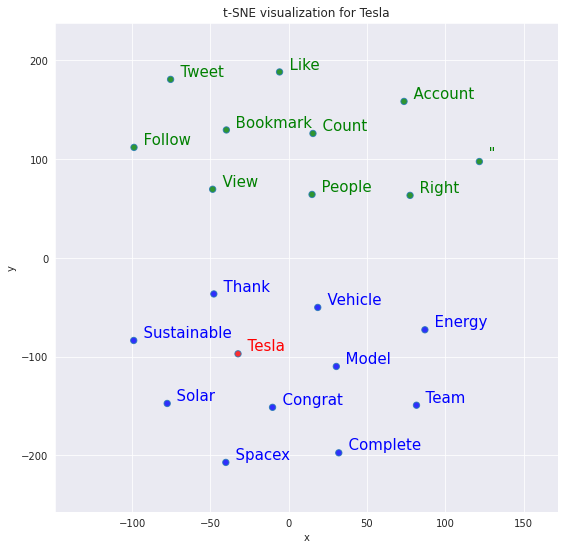

In [708]:
tsnescatterplot(w2v_model, word, [i[0] for i in w2v_model.wv.most_similar(negative=[word])])

# Play

In [713]:
#@title Try to generate a sentence similar to a context

if language == 'ru':
  from spacy.lang.ru import Russian
else:
  from spacy.lang.en import English

def generate_sentence(context):
    # Tokenize the context
    doc = nlp(context)
    # Generate the sentence
    sentence = []
    for token in doc:
        if token.is_punct or token.is_stop:
            continue
        # Use Word2Vec to select a similar word
        similar_word = w2v_model.wv.most_similar(positive=[token.lemma_])[0][0]
        # Use the original token's part of speech
        pos = token.pos_
        # Add the similar word to the sentence
        sentence.append(f'{similar_word}/{pos}')
    # Join the tokens to form a sentence
    sentence = ' '.join(sentence)
    # Capitalize the first letter of the sentence
    sentence = sentence.capitalize()
    # Add a period to the end of the sentence
    sentence += '.'
    return sentence

# Example usage
context = 'We definitely need to make people to do a lot more interactions on twitter!'
generated_sentence = generate_sentence(context)
print(generated_sentence)

General/adv lot/verb write/noun publish/noun simply/noun follow/noun.
